In [134]:
# pip install openai
# pip install tiktoken
# pip install opensearch-py
# pip install langchain-community

# Opensearch - Similarity Search

In [1]:
import pandas as pd
from langchain_community.embeddings import OpenAIEmbeddings

In [2]:
df_all = pd.read_excel ("dataset_240820.xlsx", header = None).drop_duplicates()
df_pre = pd.read_excel ("prediction dataset.xlsx").drop_duplicates()

In [3]:
embedding_model = "text-embedding-3-small"
openai_api_key = "sk-proj-fuzKGig2v3GR1nOS8WrJT3BlbkFJlehB6npoULxZkAc9hCW2"
embeddings = OpenAIEmbeddings(model = embedding_model, openai_api_key = openai_api_key)

/Users/yuxiao/miniforge3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [4]:
df_all.shape

(11076, 3)

In [5]:
texts = df_all.iloc[:, 1].tolist()  # Abstract -> Embedding (vectorize)
# metadata for output: title, abstract, journal name
metadata = df_all.iloc[:, [0, 1, 2]].rename(columns={df_all.columns[0]: 'TITLE', df_all.columns[1]: 'ABSTRACT', df_all.columns[2]: 'JOURNAL_NAME'}).to_dict(orient='records')


In [6]:
metadata

[{'TITLE': 'Coexisting single-atomic Fe and Fe2O3 on nitrogen-deficient g-C3N4 with enriched Fenton-like oxidation and photocatalytic performances for tetracycline degradation: DFT calculation, degradation mechanism and toxicity evaluation',
  'ABSTRACT': 'The regulation of heterogeneous material properties to strengthen the peroxymonosulfate activation to destroy refractory pharmaceuticals remains a challenge. Herein, a promising nitrogen-deficient catalyst (FeCN) with single atom Fe and Fe2O3 nanoparticles dispersing on g-C3N4 matrix was synthesized and applied as a competent peroxydisulfate (PDS) activator for tetracycline (TC) degradation under visible light. The K-edge X-ray absorption fine structures and 57Fe Mössbauer measurements confirmed the unique configuration of Fe2O3 and single atom Fe active sites (pyrrolic and pyridinic FeN4) induced by the neighbouring nitrogen vacancies. The theory calculations and experiments provided a deep insight into the PDS activation and TC deg

In [ ]:
from opensearchpy import OpenSearch
opensearch_url = "http://localhost:9200"
client = OpenSearch(opensearch_url)

# Check if the index already exists
if client.indices.exists(index="sa_new_all"):
    print("Index already exists. Skipping ingestion.")
else:
    vector_store = OpenSearchVectorSearch.from_texts(
        texts,
        embeddings,
        opensearch_url=opensearch_url,
        metadatas=metadata,
        index_name="sa_new_all",
        bulk_size=12000,
        timeout=60
    )

In [61]:
# https://api.python.langchain.com/en/latest/vectorstores/langchain_community.vectorstores.opensearch_vector_search.OpenSearchVectorSearch.html#langchain_community.vectorstores.opensearch_vector_search.OpenSearchVectorSearch.from_texts
from langchain.vectorstores import OpenSearchVectorSearch
opensearch_url = "http://localhost:9200"
vector_store = OpenSearchVectorSearch.from_texts(
    texts,
    embeddings,
    opensearch_url = opensearch_url,
    metadatas = metadata,
    index_name = "sa_new_all",
    bulk_size = 12000,
    timeout = 60
)


In [57]:
if vector_store.index_exists(index_name="sa_new_all"):
    vector_store.delete_index(index_name="sa_new_all")


In [16]:
df_pre.shape

(9, 2)

In [17]:
df_pre.iloc[0,1]

'Sodium–sulfur batteries have attracted attention due to their high energy capacities and low costs, but the dissolution of sodium polysulfides still severely affects their cycle life, limiting their real-world applications. Herein, a stable sulfur host is reported, based on a N,O-codoped carbon composite derived from a bimetallic Cu–Zn metal-organic framework, which ensures high sulfur loading (67 wt%). Most importantly, this composite also includes single-atom copper catalysts, with a high Cu loading of 8.03 wt%. Solid-state nuclear magnetic resonance, synchrotron X-ray absorption spectroscopy, and single-crystal X-ray diffraction analysis show that single atoms of Cu are coordinated with two N and two O atoms within the produced composite material. Those copper sites can weaken S\uf8ffS bonds in the S8 ring structure, and thus are able to catalyze the formation of short-chain sulfur molecules in even larger-size pores. In addition, Cu atoms facilitate the conversion between the shor

In [18]:
query = df_pre.iloc[0,0] +" "+ df_pre.iloc[0,1]

In [19]:
query 

'Generating Short-Chain Sulfur Suitable for Efficient Sodium–Sulfur Batteries via Atomic Copper Sites on a N,O-Codoped Carbon Composite Sodium–sulfur batteries have attracted attention due to their high energy capacities and low costs, but the dissolution of sodium polysulfides still severely affects their cycle life, limiting their real-world applications. Herein, a stable sulfur host is reported, based on a N,O-codoped carbon composite derived from a bimetallic Cu–Zn metal-organic framework, which ensures high sulfur loading (67 wt%). Most importantly, this composite also includes single-atom copper catalysts, with a high Cu loading of 8.03 wt%. Solid-state nuclear magnetic resonance, synchrotron X-ray absorption spectroscopy, and single-crystal X-ray diffraction analysis show that single atoms of Cu are coordinated with two N and two O atoms within the produced composite material. Those copper sites can weaken S\uf8ffS bonds in the S8 ring structure, and thus are able to catalyze th

In [62]:
# space_type: “l2”, “l1”, “linf”, “cosinesimil”, “innerproduct”, “hammingbit”; default: “l2”
results = vector_store.similarity_search_with_score(query, k=50, space_type = 'cosinesimil')

# vector_store.similarity_search_with_score(df_pre.iloc[0,1], k=50)

In [63]:
results

[(Document(metadata={'TITLE': 'Theoretical Calculation Guided Design of Single-Atom Catalysts toward Fast Kinetic and Long-Life Li-S Batteries', 'ABSTRACT': 'Lithium-sulfur (Li-S) batteries are promising next-generation energy storage technologies due to their high theoretical energy density, environmental friendliness, and low cost. However, low conductivity of sulfur species, dissolution of polysulfides, poor conversion from sulfur reduction, and lithium sulfide (Li2S) oxidation reactions during discharge-charge processes hinder their practical applications. Herein, under the guidance of density functional theory calculations, we have successfully synthesized large-scale single atom vanadium catalysts seeded on graphene to achieve high sulfur content (80 wt % sulfur), fast kinetic (a capacity of 645 mAh g-1 at 3 C rate), and long-life Li-S batteries. Both forward (sulfur reduction) and reverse reactions (Li2S oxidation) are significantly improved by the single atom catalysts. This fi

In [22]:
data = []
for result, score in results:
    data.append({
        'Title': result.metadata.get('TITLE', ''),
        'Abstract': result.page_content,
        'Journal_name': result.metadata.get('JOURNAL_NAME', ''),
        'Cosinesimil_Score': score
    })

In [23]:
df_results = pd.DataFrame(data)

In [24]:
df_results = pd.concat([pd.DataFrame([{'Title': df_pre.iloc[0,0], 'Abstract': df_pre.iloc[0,1]}]), df_results], ignore_index=True)


In [31]:
# TODO: Check: df_pre has 7 papers in df_all
[df_pre.iloc[i,0] in df_all.values for i in range(df_pre.shape[0])]

[True, False, True, False, True, True, True, True, True]

In [25]:
df_results

,Title,Abstract,Journal_name,Score
0,Generating Short-Chain Sulfur Suitable for Eff...,Sodium–sulfur batteries have attracted attenti...,NaN,NaN
1,Generating Short-Chain Sulfur Suitable for Eff...,Sodium–sulfur batteries have attracted attenti...,Advanced Energy Materials,0.931206
2,Low-Coordinated Zn-N2 Sites as Bidirectional A...,The rational design of advanced catalysts for ...,ACS Applied Materials and Interfaces,0.730472
3,Low-Coordinated Zn-N2 Sites as Bidirectional A...,The rational design of advanced catalysts for ...,ACS Applied Materials and Interfaces,0.730472
4,Fast conversion and controlled deposition of l...,Lithium-sulfur (Li–S) batteries are appealing ...,Energy Storage Materials,0.727004
5,"Atomically dispersed Co anchored on N,S-riched...",Lithium-sulfur (Li-S) battery possess the adva...,Journal of Alloys and Compounds,0.718673
6,Implanting Single Zn Atoms Coupled with Metall...,The electrochemical performance of lithium-sul...,Advanced Functional Materials,0.714262
7,Single Zinc Atom Aggregates: Synergetic Intera...,Single-atom catalysts (SACs) pave new possibil...,Advanced Materials,0.711447
8,Single Zinc Atom Aggregates: Synergetic Intera...,Single-atom catalysts (SACs) pave new possibil...,Advanced Materials,0.711447
9,Enhanced Dual-Directional Sulfur Redox via a B...,The lithium–sulfur (Li–S) battery is considere...,Advanced Materials,0.708325


In [75]:
dfs_results = []

# Loop 
for i in range(df_pre.shape[0]):
    # query = df_pre.iloc[i, 0] + " " + df_pre.iloc[i, 1]
    query = df_pre.iloc[i, 1]
    results = vector_store.similarity_search_with_score(query, k=100, space_type='cosinesimil')

    data = []
    for result, score in results:
        data.append({
            'Title': result.metadata.get('TITLE', ''),
            'Abstract': result.page_content,
            'Journal_name': result.metadata.get('JOURNAL_NAME', ''),
            'Cosinesimil_Score': score
        })
    
    df_results = pd.DataFrame(data)
    df_results = pd.concat([pd.DataFrame([{'Title': df_pre.iloc[i, 0], 'Abstract': df_pre.iloc[i, 1]}]), df_results], ignore_index=True)
    
    dfs_results.append(df_results)

In [65]:
output_name = 'output_multiple_sheets_top100_abs.xlsx'

with pd.ExcelWriter(output_name, engine='xlsxwriter') as writer:
    for i, df in enumerate(dfs_results):
        sheet_name = f'Sheet{i+1}'
        
        df.to_excel(writer, index=False, sheet_name=sheet_name)


## TSNE

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine titles and abstracts for vectorization
documents = [row['Title'] + " " + row['Abstract'] for df in dfs_results for _, row in df.iterrows()]

# Vectorize the combined text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)


In [77]:
len(documents)

909

In [78]:
from sklearn.cluster import KMeans

# Perform K-Means clustering with an arbitrary number of clusters (e.g., 5)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Get the cluster labels for each document
cluster_labels = kmeans.labels_


In [79]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce the dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())  # Convert sparse matrix to dense if needed


/Users/yuxiao/miniforge3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/yuxiao/miniforge3/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [80]:
len(X_tsne)

909

In [82]:
df_tsne = pd.DataFrame(X_tsne, columns=['Dimension 1', 'Dimension 2'])
df_tsne.to_csv('tsne_results.csv', index=False)

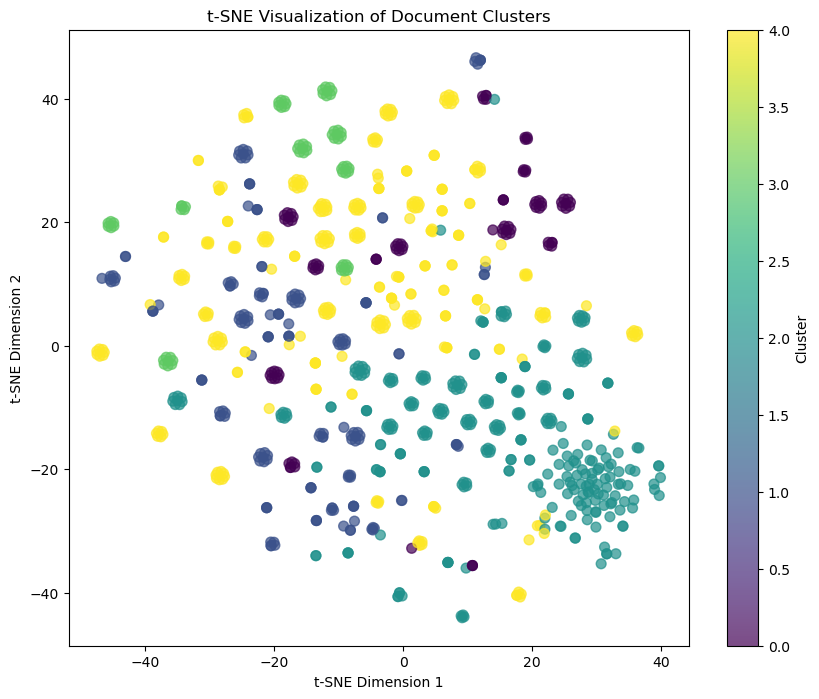

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for the t-SNE results with cluster labels
df_tsne = pd.DataFrame({'x': X_tsne[:, 0], 'y': X_tsne[:, 1], 'Cluster': cluster_labels})

# Plot the t-SNE results with clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_tsne['x'], df_tsne['y'], c=df_tsne['Cluster'], cmap='viridis', s=50, alpha=0.7)
plt.title('t-SNE Visualization of Document Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(scatter, label='Cluster')
plt.show()


# OpenAI

In [69]:
dfs_results[0].iloc[0,1]

'Sodium–sulfur batteries have attracted attention due to their high energy capacities and low costs, but the dissolution of sodium polysulfides still severely affects their cycle life, limiting their real-world applications. Herein, a stable sulfur host is reported, based on a N,O-codoped carbon composite derived from a bimetallic Cu–Zn metal-organic framework, which ensures high sulfur loading (67 wt%). Most importantly, this composite also includes single-atom copper catalysts, with a high Cu loading of 8.03 wt%. Solid-state nuclear magnetic resonance, synchrotron X-ray absorption spectroscopy, and single-crystal X-ray diffraction analysis show that single atoms of Cu are coordinated with two N and two O atoms within the produced composite material. Those copper sites can weaken S\uf8ffS bonds in the S8 ring structure, and thus are able to catalyze the formation of short-chain sulfur molecules in even larger-size pores. In addition, Cu atoms facilitate the conversion between the shor

In [70]:
from openai import OpenAI
client = OpenAI(api_key = "sk-proj-fuzKGig2v3GR1nOS8WrJT3BlbkFJlehB6npoULxZkAc9hCW2")
completion = client.chat.completions.create(
  model="gpt-4o",
  messages=[
      {"role": "user", "content": f"Based on the abstract, summarize what chemical reaction the article is about and what catalyst is used. The abstrac: {dfs_results[0].iloc[0,1]}"}
  ]
)

ChatCompletionMessage(content='The article discusses a chemical reaction within sodium–sulfur batteries, specifically addressing the issue of sodium polysulfide dissolution, which affects the longevity of these batteries. The study involves a N,O-codoped carbon composite derived from a bimetallic Cu–Zn metal-organic framework as a stable sulfur host. This composite includes single-atom copper catalysts, with a high copper loading, which play a crucial role. The single-atom copper sites can weaken the S–S bonds in the S8 ring structure, catalyzing the formation of short-chain sulfur molecules and facilitating the conversion between short-chain sulfur and Na2S. Consequently, this setup allows the battery to achieve superior capacity and high sulfur utilization, enhancing its performance and cycle life.', role='assistant', function_call=None, tool_calls=None, refusal=None)


In [71]:
print(completion.choices[0].message.content)

The article discusses a chemical reaction within sodium–sulfur batteries, specifically addressing the issue of sodium polysulfide dissolution, which affects the longevity of these batteries. The study involves a N,O-codoped carbon composite derived from a bimetallic Cu–Zn metal-organic framework as a stable sulfur host. This composite includes single-atom copper catalysts, with a high copper loading, which play a crucial role. The single-atom copper sites can weaken the S–S bonds in the S8 ring structure, catalyzing the formation of short-chain sulfur molecules and facilitating the conversion between short-chain sulfur and Na2S. Consequently, this setup allows the battery to achieve superior capacity and high sulfur utilization, enhancing its performance and cycle life.
